In [1]:
import os
from skimage import io
import csv
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
RESOLUTION = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=RESOLUTION, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=transforms.InterpolationMode.BICUBIC),
    v2.RandomRotation(20),  # Randomly rotate images by a certain degree
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

# Define a transform for the validation data without data augmentation
val_transform = transforms.Compose([
    v2.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.BICUBIC),  # Resize images to a common size
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

In [4]:
csv_path = 'train_labeled.csv'
labeled_path = 'train/labeled'

class CustomDataset(Dataset):
    def __init__(self, csv_file, train_path, transform=None):
        self.train_labeled = train_path
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.train_labeled + '/' + self.df.image[idx]
        image = datasets.folder.default_loader(img_path)
        label = self.df.id[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

labeled_train_dataset = CustomDataset(csv_path, labeled_path, train_transform)
labeled_val_dataset = CustomDataset(csv_path, labeled_path, val_transform)

num_train = len(labeled_train_dataset)
indices = list(range(num_train))
split_idx = int(np.floor(.1 * num_train))
valid_idx, train_idx = indices[:split_idx], indices[split_idx:]

train_indices, val_indices = train_test_split(indices, test_size=.2)
labeled_train_dataset = torch.utils.data.Subset(labeled_train_dataset, train_indices)
labeled_val_dataset = torch.utils.data.Subset(labeled_val_dataset, val_indices)

In [5]:
print(len(labeled_train_dataset), len(labeled_val_dataset))

7883 1971


In [6]:
BATCH_SIZE = 1
train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_label_loader = DataLoader(dataset=labeled_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


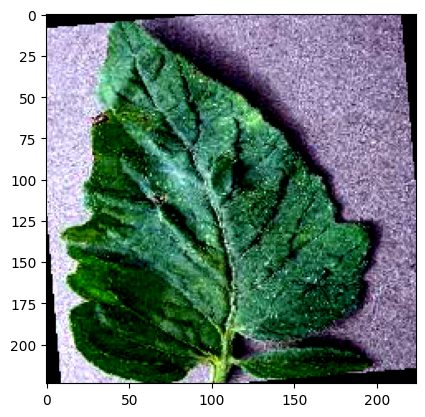

In [7]:
def imshow(img, un):
    if(un):
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_iter = iter(train_label_loader)
images, labels = next(train_iter)
print(labels[0])
imshow(make_grid(images[0]), True)

In [8]:
test_dir = 'test'

# For the test set, since there are no labels, we need to create a custom DataSet.
class UnlabeledDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(UnlabeledDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)

# Create a dataset for your test data
test_dataset = UnlabeledDataset(root=test_dir, transform=val_transform)

# Create a DataLoader for your test set
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
vit_l16 = torch.hub.load("facebookresearch/swag", model="vit_l16")


Using cache found in /home/jupyter/.cache/torch/hub/facebookresearch_swag_main


In [10]:
class ModifiedViT(nn.Module):
    def __init__(self, pretrained_model):
        super(ModifiedViT, self).__init__()
        self.pretrained = pretrained_model
        self.pretrained.head = nn.Identity()  # remove the existing linear layer
        for param in self.pretrained.parameters():
            param.requires_grad = False

        self.new_head = nn.Sequential(
            nn.Linear(1024, 135),  # Adjust the input size to match the output size of the ViT model
        )

    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_head(x)
        return x

# Create the modified model
model = ModifiedViT(vit_l16)

In [11]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.new_head.parameters(), lr=0.001, weight_decay=0.005)

In [12]:
# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 3  # Replace with the number of epochs you want

# Lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_label_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / (tepoch.n + 1)), accuracy=(correct_predictions / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_label_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        with tqdm(val_label_loader, unit="batch") as vepoch:
            for images, labels in vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                vepoch.set_postfix(val_loss=(val_running_loss / (vepoch.n + 1)), val_accuracy=(val_correct_predictions / val_total_predictions))

    # Calculate and print loss and accuracy for the validation phase
    val_epoch_loss = val_running_loss / len(val_label_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Validation Epoch 1/3: 100%|██████████| 1971/1971 [02:13<00:00, 14.74batch/s, val_accuracy=0.742, val_loss=1.35]


Epoch [1/3], Train Loss: 1.8299, Train Accuracy: 0.6369, Val Loss: 1.3526, Val Accuracy: 0.7418


Validation Epoch 2/3: 100%|██████████| 1971/1971 [01:51<00:00, 17.65batch/s, val_accuracy=0.734, val_loss=1.36]


Epoch [2/3], Train Loss: 1.4665, Train Accuracy: 0.7214, Val Loss: 1.3642, Val Accuracy: 0.7341


Validation Epoch 3/3: 100%|██████████| 1971/1971 [01:50<00:00, 17.78batch/s, val_accuracy=0.743, val_loss=1.35]

Epoch [3/3], Train Loss: 1.3512, Train Accuracy: 0.7451, Val Loss: 1.3484, Val Accuracy: 0.7428


In [14]:
torch.save(model.state_dict(), 'model.pt')

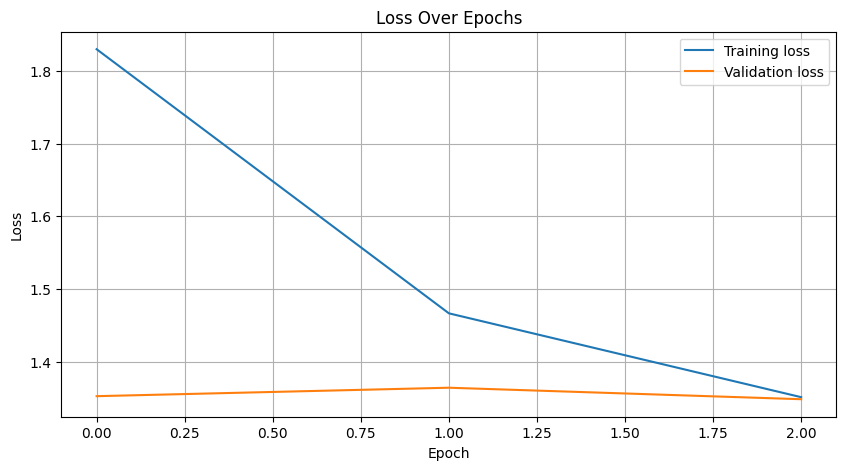

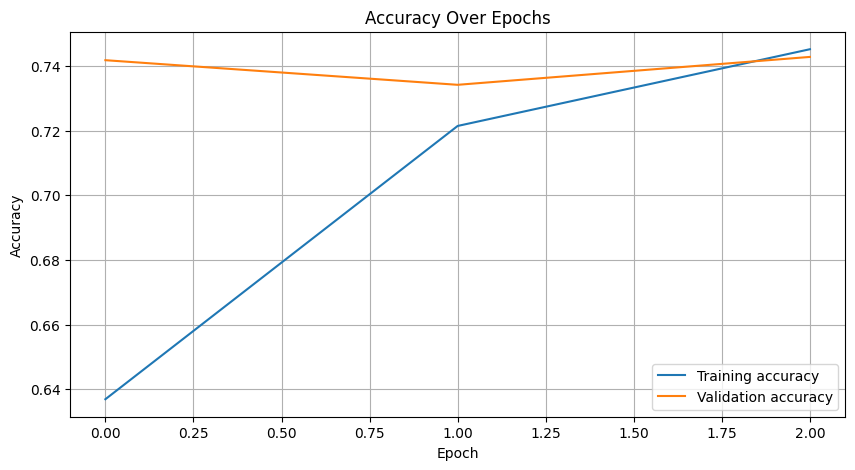

In [15]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Model's evaluation mode
model.eval()

test_predictions = []

# Assuming the model is already in evaluation mode and device is defined
with torch.no_grad():
    for images, paths in tqdm(test_loader, desc='Predicting labels'):
        images = images.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Go through the batch and add to our prediction list, including image paths
        for path, label in zip(paths, predicted):
            test_predictions.append((Path(path).name, label))  # Appending a tuple of filename and label

with open('test_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'id'])
    writer.writerows(test_predictions)  # Writing all predictions at once

Predicting labels: 100%|██████████| 8213/8213 [07:14<00:00, 18.89it/s]


In [47]:
import re

m = re.search('\(([^\)]+)\)', 'ab(c)def')
m.group(0)

df = pd.read_csv('test_predictions.csv')
new_col = df['id'][0]
new_col[new_col.find("(")+1:new_col.find(",")]

for i in range(len(df['id'])):
    val = df['id'][i]
    val = val[val.find("(")+1:val.find(",")]
    df['id'][i] = val
df.to_csv('pred.csv')
    